# Week 4 
# Neural Networks : Intro

This week brings us to the point where we get a taste of the mighty neural networks which are the building blocks of deep learning. We will not go too deep into the subject but would, however, look at how these networks are represented and how data propagate through them. Before looking at neural networks, we will take some time to revise all what we have done in the past. K-Nearest Neighbors, Multi-class SVM and Softmax regression wil be revisited.



#### download cifar10 dataset

In [0]:
%%bash
# Get CIFAR10
wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
tar -xzvf cifar-10-python.tar.gz
rm cifar-10-python.tar.gz 


#### define functions for loading data as in cs231n assignments datautils.py

In [0]:
#@title data loading functions
from __future__ import print_function

from six.moves import cPickle as pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.misc import imread
import platform

def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = load_pickle(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte


def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000,
                     subtract_mean=True):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for classifiers. These are the same steps as we used for the SVM, but
    condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    if subtract_mean:
      mean_image = np.mean(X_train, axis=0)
      X_train -= mean_image
      X_val -= mean_image
      X_test -= mean_image
    
    # Transpose so that channels come first
    X_train = X_train.transpose(0, 3, 1, 2).copy()
    X_val = X_val.transpose(0, 3, 1, 2).copy()
    X_test = X_test.transpose(0, 3, 1, 2).copy()

    # Package data into a dictionary
    return {
      'X_train': X_train, 'y_train': y_train,
      'X_val': X_val, 'y_val': y_val,
      'X_test': X_test, 'y_test': y_test,
    }
    

def load_tiny_imagenet(path, dtype=np.float32, subtract_mean=True):
  """
  Load TinyImageNet. Each of TinyImageNet-100-A, TinyImageNet-100-B, and
  TinyImageNet-200 have the same directory structure, so this can be used
  to load any of them.

  Inputs:
  - path: String giving path to the directory to load.
  - dtype: numpy datatype used to load the data.
  - subtract_mean: Whether to subtract the mean training image.

  Returns: A dictionary with the following entries:
  - class_names: A list where class_names[i] is a list of strings giving the
    WordNet names for class i in the loaded dataset.
  - X_train: (N_tr, 3, 64, 64) array of training images
  - y_train: (N_tr,) array of training labels
  - X_val: (N_val, 3, 64, 64) array of validation images
  - y_val: (N_val,) array of validation labels
  - X_test: (N_test, 3, 64, 64) array of testing images.
  - y_test: (N_test,) array of test labels; if test labels are not available
    (such as in student code) then y_test will be None.
  - mean_image: (3, 64, 64) array giving mean training image
  """
  # First load wnids
  with open(os.path.join(path, 'wnids.txt'), 'r') as f:
    wnids = [x.strip() for x in f]

  # Map wnids to integer labels
  wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}

  # Use words.txt to get names for each class
  with open(os.path.join(path, 'words.txt'), 'r') as f:
    wnid_to_words = dict(line.split('\t') for line in f)
    for wnid, words in wnid_to_words.iteritems():
      wnid_to_words[wnid] = [w.strip() for w in words.split(',')]
  class_names = [wnid_to_words[wnid] for wnid in wnids]

  # Next load training data.
  X_train = []
  y_train = []
  for i, wnid in enumerate(wnids):
    if (i + 1) % 20 == 0:
      print('loading training data for synset %d / %d' % (i + 1, len(wnids)))
    # To figure out the filenames we need to open the boxes file
    boxes_file = os.path.join(path, 'train', wnid, '%s_boxes.txt' % wnid)
    with open(boxes_file, 'r') as f:
      filenames = [x.split('\t')[0] for x in f]
    num_images = len(filenames)
    
    X_train_block = np.zeros((num_images, 3, 64, 64), dtype=dtype)
    y_train_block = wnid_to_label[wnid] * np.ones(num_images, dtype=np.int64)
    for j, img_file in enumerate(filenames):
      img_file = os.path.join(path, 'train', wnid, 'images', img_file)
      img = imread(img_file)
      if img.ndim == 2:
        ## grayscale file
        img.shape = (64, 64, 1)
      X_train_block[j] = img.transpose(2, 0, 1)
    X_train.append(X_train_block)
    y_train.append(y_train_block)
      
  # We need to concatenate all training data
  X_train = np.concatenate(X_train, axis=0)
  y_train = np.concatenate(y_train, axis=0)
  
  # Next load validation data
  with open(os.path.join(path, 'val', 'val_annotations.txt'), 'r') as f:
    img_files = []
    val_wnids = []
    for line in f:
      img_file, wnid = line.split('\t')[:2]
      img_files.append(img_file)
      val_wnids.append(wnid)
    num_val = len(img_files)
    y_val = np.array([wnid_to_label[wnid] for wnid in val_wnids])
    X_val = np.zeros((num_val, 3, 64, 64), dtype=dtype)
    for i, img_file in enumerate(img_files):
      img_file = os.path.join(path, 'val', 'images', img_file)
      img = imread(img_file)
      if img.ndim == 2:
        img.shape = (64, 64, 1)
      X_val[i] = img.transpose(2, 0, 1)

  # Next load test images
  # Students won't have test labels, so we need to iterate over files in the
  # images directory.
  img_files = os.listdir(os.path.join(path, 'test', 'images'))
  X_test = np.zeros((len(img_files), 3, 64, 64), dtype=dtype)
  for i, img_file in enumerate(img_files):
    img_file = os.path.join(path, 'test', 'images', img_file)
    img = imread(img_file)
    if img.ndim == 2:
      img.shape = (64, 64, 1)
    X_test[i] = img.transpose(2, 0, 1)

  y_test = None
  y_test_file = os.path.join(path, 'test', 'test_annotations.txt')
  if os.path.isfile(y_test_file):
    with open(y_test_file, 'r') as f:
      img_file_to_wnid = {}
      for line in f:
        line = line.split('\t')
        img_file_to_wnid[line[0]] = line[1]
    y_test = [wnid_to_label[img_file_to_wnid[img_file]] for img_file in img_files]
    y_test = np.array(y_test)
  
  mean_image = X_train.mean(axis=0)
  if subtract_mean:
    X_train -= mean_image[None]
    X_val -= mean_image[None]
    X_test -= mean_image[None]

  return {
    'class_names': class_names,
    'X_train': X_train,
    'y_train': y_train,
    'X_val': X_val,
    'y_val': y_val,
    'X_test': X_test,
    'y_test': y_test,
    'class_names': class_names,
    'mean_image': mean_image,
  }


def load_models(models_dir):
  """
  Load saved models from disk. This will attempt to unpickle all files in a
  directory; any files that give errors on unpickling (such as README.txt) will
  be skipped.

  Inputs:
  - models_dir: String giving the path to a directory containing model files.
    Each model file is a pickled dictionary with a 'model' field.

  Returns:
  A dictionary mapping model file names to models.
  """
  models = {}
  for model_file in os.listdir(models_dir):
    with open(os.path.join(models_dir, model_file), 'rb') as f:
      try:
        models[model_file] = load_pickle(f)['model']
      except pickle.UnpicklingError:
        continue
  return models


#### load in the cifar10 train and test sets

In [0]:
# Load the raw CIFAR-10 data.
cifar10_dir = './cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


visualize some of the images in the train set. 10 images per class.

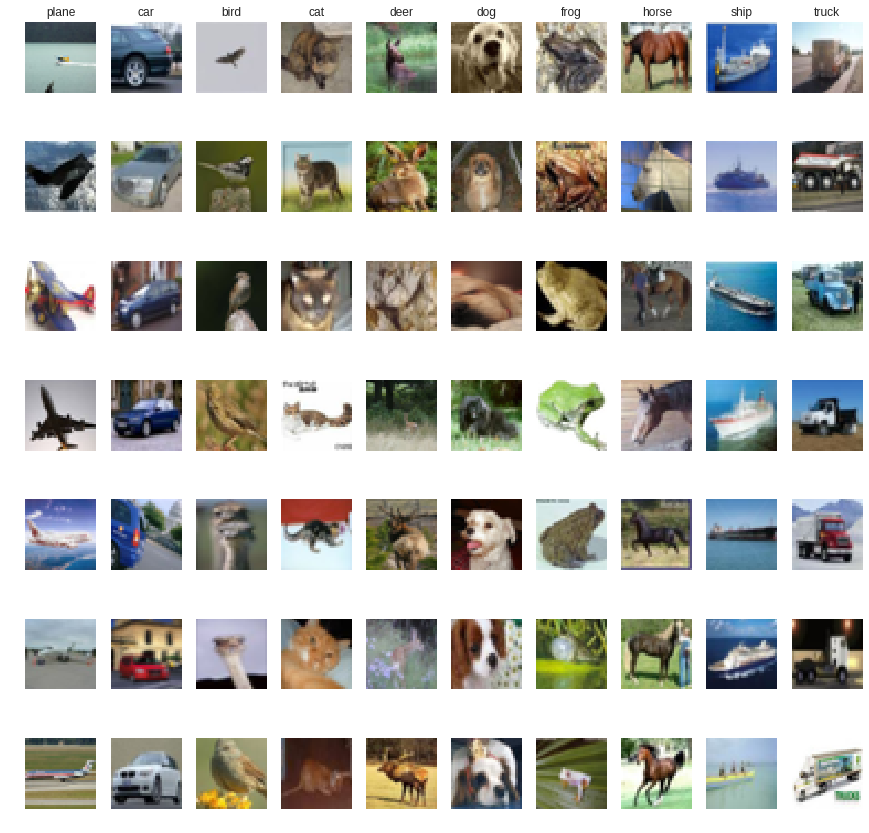

In [0]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
plt.figure(figsize=(15,15))
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

# RECAP

Previously, we treated how to use the data-driven approach to solve the object recognition problem. We considered some learning algorithms that can be applied to the task of object recognition and how well these algorithms perform. We explored K-Nearest Neighbors, multi-class SVM and softmax regression. Before moving to Neural Networks, We will build these models and train them on the cifar10 dataset.

K-Nearest Neighbors

In [0]:
class KNN(object):
  def __init__(self):
    pass
  
  def train(self, X, y):
    self.X_train = X
    self.y_train = y
  
  def predict(self, X, k=1):
    dists = self.get_dists_matrix(X)
    
    y_test = np.zeros(X.shape[0], dtype=np.int)
    for i in range(X.shape[0]):
      
      ys = self.y_train[np.argsort(dists[i])][:k]
      
      y_test[i] = np.argmax(np.bincount(ys))
      
    return y_test
  
  def get_dists_matrix(self, X):
    return np.sqrt((X**2).sum(axis=1, keepdims=True) + (self.X_train**2).sum(axis=1) - 2 * X.dot(self.X_train.T))

multi-class SVM

In [0]:
class SVM(object):
  def __init__(self):
    pass
  
  def train(self, X, y, lr=0.003, reg=0.001):
    self.loss = []
    number_of_classes = int(np.max(y))+1
    self.W = np.random.normal(0,.1,(X.shape[1], number_of_classes))
    self.b = np.zeros(number_of_classes).reshape(1,-1)
    
    patience = 10
    loss_increase_count = 0
    i = 0
    
    while(loss_increase_count <= patience):
  
      # one epoch training
      self.one_epoch(X, y,reg)

      # update parameters
      self.W -= lr*self.dW
      self.b -= lr*self.db
      
      if self.loss[i] > self.loss[i-1]:
        loss_increase_count += 1
      else:
        loss_increase_count = 0
        
      # display
      if i % 100 == 0:
        print(str(i), 'loss: ', self.loss[i])
      i += 1
    
  def one_epoch(self, X, y, reg):
    
    
    
    # forward
    scores = X.dot(self.W)+self.b
    
    # loss
    correct_scores = scores[np.arange(X.shape[0]), y].reshape((-1,1))
    margins = np.maximum(0, scores - correct_scores + 1)
    margins[np.arange(X.shape[0]), y] = 0
    loss = np.sum(margins)
    loss /= X.shape[0]
    loss += 0.5*reg * np.sum(self.W**2)
    
    self.loss += [loss]
    
    # gradients
    X_mask = np.zeros(margins.shape)
    X_mask[margins > 0] = 1
    X_mask[np.arange(X.shape[0]), y] = -np.sum(X_mask, axis=1)
    self.dW = X.T.dot(X_mask)
    self.db = np.sum(X_mask, axis=0)
    
    self.dW /= X.shape[0]
    self.db /= X.shape[0]
    self.dW += reg*self.W
    
  
  def predict(self, X):
    return np.argmax(X.dot(self.W)+self.b, axis=1)

**Softmax**

In [0]:
# not properly implemented !

class SoftmaxClassifier(object):
  def __init__(self):
    pass
  
  def train(self, X, y, lr=0.003, reg=0.001):
    
    self.loss = []
    number_of_classes = int(np.max(y))+1
    self.W = np.random.normal(0,.1,(X.shape[1], number_of_classes))
    self.b = np.zeros(number_of_classes).reshape(1,-1)
    
    patience = 10
    loss_increase_count = 0
    i = 0
    
    while(loss_increase_count <= patience):
  
      # one epoch training
      self.one_epoch(X, y,reg)

      # update parameters
      self.W -= lr*self.dW
      self.b -= lr*self.db
      
      if self.loss[i] > self.loss[i-1]:
        loss_increase_count += 1
      else:
        loss_increase_count = 0
        
      # display
      if i % 100 == 0:
        print(str(i), 'loss: ', self.loss[i])
      i += 1
    
  def one_epoch(self, X, y, reg):
    
    
    num_classes = int(np.max(y))+1

    num_train = X.shape[0]
    self.W = np.random.normal(0,.1,(X.shape[1],num_classes))
    logit = X.dot(self.W) + self.b
    s = logit - np.max(logit, axis=1, keepdims=True)
    exp_s = np.exp(s)
    sum_exp_s = np.sum(exp_s, axis=1, keepdims=True)
    probs = exp_s/sum_exp_s

    loss = np.sum(-1*(logit[np.arange(num_train), y] - np.log(sum_exp_s) - np.max(logit, axis=1, keepdims=True))) 
    
    

    labels = np.zeros_like(probs)
    labels[np.arange(num_train), y] = 1
    self.dW = X.T.dot(probs - labels)
    self.db = np.sum(probs - labels, axis=0)

    loss /= num_train
    loss += 0.5 * reg * np.sum(self.W * self.W)
    self.dW /= num_train
    self.db /= num_train
    self.dW += reg*self.W
    
    self.loss += [loss]
  
  def predict(self):
    return np.argmax(X.dot(self.W)+self.b, axis=1)

### Using the implemented classifiers

In [0]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]


# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [0]:
# feature scaling and normalization
meanX = np.mean(X_train, 0)
stdX = np.std(X_train, 0)

X_train_norm = (X_train-meanX)/stdX
X_test_norm = (X_test-meanX)/stdX

train svm

In [0]:
sv = SVM()
sv.train(X_train_norm, y_train)

train softmax

In [0]:
sf = SoftmaxClassifier()
sf.train(X_train_norm, y_train)

0 loss:  36572.03130387269
100 loss:  42442.03763195752
200 loss:  49761.086751730916
300 loss:  46219.24515792308
400 loss:  43589.52152045344
500 loss:  50650.54594615932
600 loss:  37520.40906024611
700 loss:  43678.685622074394
800 loss:  45840.03725913717
900 loss:  49401.33425247259
1000 loss:  41435.88375552828
1100 loss:  39534.949424107515
1200 loss:  41845.77622389819
1300 loss:  40700.12583656247
1400 loss:  38734.317682436325
1500 loss:  39943.50287237678
1600 loss:  43527.2026874918
1700 loss:  40999.145806288514
1800 loss:  41926.974482538295
1900 loss:  34505.09886417203
2000 loss:  45827.94031691054
2100 loss:  46231.25717737188
2200 loss:  38710.34336888629
2300 loss:  37827.632245039975
2400 loss:  42055.19846484655
2500 loss:  38656.04851308523
2600 loss:  37180.04777819257
2700 loss:  39171.027546608275
2800 loss:  44781.091029839336
2900 loss:  40216.6303548136
3000 loss:  44084.14332607086
3100 loss:  41279.08262444915
3200 loss:  44390.908429287716
3300 loss:  43